In [ ]:
#|default_exp tmp

# Original Chris 94.9 on 5ep (not reporduced)

In [ ]:
import pickle,gzip,math,os,time,shutil,torch,random
import fastcore.all as fc,matplotlib as mpl,numpy as np,matplotlib.pyplot as plt
from collections.abc import Mapping
from pathlib import Path
from operator import attrgetter,itemgetter
from functools import partial
from copy import copy
from contextlib import contextmanager

import torchvision.transforms.functional as TF,torch.nn.functional as F
from torch import tensor,nn,optim
from torch.utils.data import DataLoader,default_collate
from torch.nn import init
from torch.optim import lr_scheduler
from torcheval.metrics import MulticlassAccuracy
from datasets import load_dataset,load_dataset_builder

from miniai.datasets import *
from miniai.conv import *
from miniai.learner import *
from miniai.activations import *
from miniai.init import *
from miniai.sgd import *
from miniai.resnet import *

In [ ]:
# speed mods
from miniai.utils import *

MetricsCB = LazyMetricsCB
ProgressCB = LazyProgressCB

In [ ]:
from fastcore.test import test_close
from torch import distributions

torch.set_printoptions(precision=8, linewidth=140, sci_mode=False)
mpl.rcParams['image.cmap'] = 'gray'

import logging
logging.disable(logging.WARNING)

if fc.defaults.cpus>8: fc.defaults.cpus=8

In [ ]:
xl,yl = 'image','label'
name = "fashion_mnist"
bs = 256
xmean,xstd = 0.28, 0.35

@inplace
def transformi(b): b[xl] = [(TF.to_tensor(o)-xmean)/xstd for o in b[xl]]

dsd = load_dataset(name)
tds = dsd.with_transform(transformi)


  0%|          | 0/2 [00:00<?, ?it/s]

In [ ]:
tds.cached = cache_dataset_as_dict(tds)

In [ ]:
def get_model9(act=nn.ReLU, nfs=(32,288,288,288,288,288), norm=nn.BatchNorm2d):#,256
    layers = [ResBlock(1, 32, ks=5, stride=1, act=act, norm=norm)]
    layers += [ResBlock(nfs[i], nfs[i+1], act=act, norm=norm, stride=2) for i in range(len(nfs)-1)]
    layers += [nn.Flatten(), nn.Linear(nfs[-1], 10, bias=False), nn.BatchNorm1d(10)]
    return nn.Sequential(*layers).to(def_device)

In [ ]:
from torchvision import transforms

In [ ]:
def tfm_batch(b, tfm_x=fc.noop, tfm_y = fc.noop): return tfm_x(b[0]),tfm_y(b[1])

In [ ]:
tfms = nn.Sequential(transforms.RandomCrop(28, padding=1),
                     transforms.RandomHorizontalFlip(0.65))
augcb = BatchTransformCB(partial(tfm_batch, tfm_x=tfms), on_val=False)

# run

In [ ]:
dls = DataLoaders.from_dd(tds.cached, bs, num_workers=0)

# tweaked from rohitgeo's version
metrics = MetricsCB(accuracy=MulticlassAccuracy())
cbs = [DeviceCB(), metrics] 
#0.0003 from https://github.com/digantamisra9

In [ ]:
def upscale_cb(scale, mode='bilinear'): 
    return BatchTransformCB(lambda b: (F.interpolate(b[0], scale_factor=scale, mode=mode),b[1]),
                            on_val=True, on_train=True)

In [ ]:
import timm

In [ ]:
rng = rng_seed

In [ ]:
def run(model, leaky=0.0003, m=1, cbs=tuple(), fit=True, train_cb=TrainCB(), epochs=5, base_lr=2e-2, 
        loss_func=F.cross_entropy, bs=bs, tta=False, dls=None, verbose=True):
    iw = partial(init_weights, leaky=leaky) if leaky is not None else fc.noop
    lr = base_lr*m
    print("Batch size", bs*m)
    dls = dls or DataLoaders.from_dd(tds.cached, bs*m, num_workers=0) 
    tmax = epochs * len(dls.train)
    sched = partial(lr_scheduler.OneCycleLR, max_lr=lr, total_steps=tmax)
    
    cbs = [DeviceCB(), rng_seed, metrics, BatchSchedCB(sched), *cbs, train_cb] 
    learn = Learner(model.apply(iw), dls, loss_func, lr=lr, cbs=cbs, opt_func=optim.AdamW)
    if verbose: 
        print(torch.randn([3]))
        print(next(iter(learn.dls.train))[1])
    if fit:
        learn.fit(epochs, cbs=[TimeItCB(), ProgressCB(plot=True)])
    if tta:
        ## TTA
        ap1, at = learn.capture_preds()
        ttacb = BatchTransformCB(partial(tfm_batch, tfm_x=TF.hflip), on_val=True)
        ap2, at = learn.capture_preds(cbs=[ttacb])
        ap = torch.stack([ap1,ap2]).mean(0).argmax(1)
        if verbose: print('TTA:', round((ap==at).float().mean().item(), 4))
    
    return learn

# MixUp v3

In [ ]:
xb,yb = fc.first(dls.train)

In [ ]:
yab = torch.tensor([1.,0.,0.,1.])
s = torch.tensor([0.1,0.2,0.3,0.4])

#yab.T @ s @ yab


In [ ]:
from types import SimpleNamespace
def mixup_data(b2, b1=None, sampler=torch.distributions.Beta(tensor(0.5), tensor(0.5)).sample, classes=10, permute_1=True):
    '''Returns mixed inputs, pairs of targets, and lambda'''
    r = SimpleNamespace()    
    if b1 is None: b1=b2 # first batch uses it self
    x1,y1 = b1
    x2,y2 = b2
    
    if x1.shape[0] != x2.shape[0]: x1,y1=x2,y2 # last batch uses it self

    batch_size = x2.shape[0]
    r.lam = sampler([batch_size]).to(x2.device)
    
    # permute prev batch
    if permute_1:
        r.index = torch.randperm(batch_size).to(x2.device)
        x1,y1 = x1[r.index], y1[r.index]
    
    #r.mixed_x = r.lam.reshape(-1,*[1]*(len(x2.shape)-1)) * x2 + (1 - r.lam.reshape(-1,*[1]*(len(x2.shape)-1))) * x1
    r.mixed_x = torch.lerp(x2, x1, r.lam.reshape(-1,*[1]*(len(x2.shape)-1)))
    
    r.y1 = F.one_hot(y1, num_classes=classes).float()
    r.y2 = F.one_hot(y2, num_classes=classes).float()
    #r.mixed_y = r.y2 + r.lam.reshape(-1,1)*(r.y1-r.y2)
    r.mixed_y = torch.lerp(r.y2, r.y1, r.lam.reshape(-1,*[1]*(len(r.y2.shape)-1)))
    return r


tensor([    0.97486794,     0.99995714,     0.77728915,     0.00005185,     0.72436720,     0.85924667,     0.51449543,     0.67873859,
            0.64951372,     0.99581611,     0.16120158,     0.01715988,     0.99692017,     0.87783694,     0.78210938,     0.74834800])

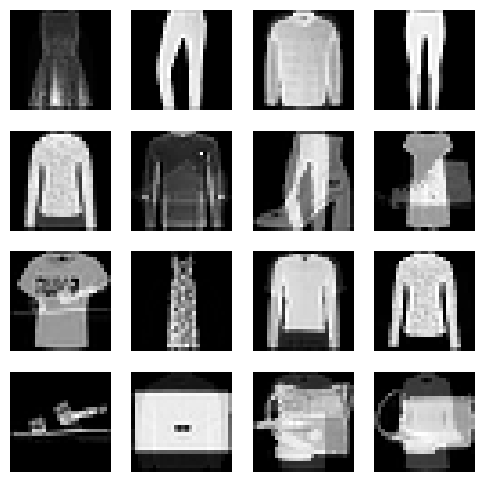

In [ ]:
r = mixup_data((xb,yb))
show_images(r.mixed_x[:16], imsize=1.5)
r.lam[:16]

In [ ]:
torch.lerp??

Docstring:
lerp(input, end, weight, *, out=None)

Does a linear interpolation of two tensors :attr:`start` (given by :attr:`input`) and :attr:`end` based
on a scalar or tensor :attr:`weight` and returns the resulting :attr:`out` tensor.

.. math::
    \text{out}_i = \text{start}_i + \text{weight}_i \times (\text{end}_i - \text{start}_i)

The shapes of :attr:`start` and :attr:`end` must be
:ref:`broadcastable <broadcasting-semantics>`. If :attr:`weight` is a tensor, then
the shapes of :attr:`weight`, :attr:`start`, and :attr:`end` must be :ref:`broadcastable <broadcasting-semantics>`.

Args:
    input (Tensor): the tensor with the starting points
    end (Tensor): the tensor with the ending points
    weight (float or tensor): the weight for the interpolation formula

Keyword args:
    out (Tensor, optional): the output tensor.

Example::

    >>> start = torch.arange(1., 5.)
    >>> end = torch.empty(4).fill_(10)
    >>> start
    tensor([ 1.,  2.,  3.,  4.])
    >>> end
    tensor([ 1

In [ ]:
def mce(preds, r, eta=None, **kw): return F.cross_entropy(preds, r.mixed_y,**kw)

## MixUp4CB

In [ ]:
class MixUp4CB(TrainCB):
    def __init__(self,alpha=0.4, use_prev=False, eta=0.1, per_batch=False, loss_func=dmce, label_smoothing=None, **kw): 
        super().__init__(**kw)
        self.alpha = alpha or 0.0
        self.dist = torch.distributions.Beta(self.alpha, self.alpha)
        self.prev = None
        self.use_prev = use_prev
        self.eta = eta 
        self.per_batch = per_batch
        self.loss_func = loss_func
        self.label_smoothing = label_smoothing
    def before_epoch(self, learn):
        self.prev = None
            
    def sample(self, shape): 
        if self.per_batch: return self.dist.sample([1])
        return self.dist.sample(shape)
    
    def before_batch(self, learn):
        if learn.training and self.alpha: 
            r = mixup_data(learn.batch, self.prev, sampler=self.sample)
            if self.use_prev: self.prev = learn.batch
            learn.mixup = r
            learn.batch = r.mixed_x, r.mixed_y.argmax(-1)
            
    def get_loss(self, learn):
        if learn.training and self.alpha:
            learn.loss = self.loss_func(learn.preds, learn.mixup, eta=self.eta, label_smoothing=self.label_smoothing)
        else:
            super().get_loss(learn)

## Compare with previous implementation

In [ ]:
def mixup_data_per_batch(x, y, sampler=torch.distributions.Beta(tensor(1), tensor(1)).sample):
    '''Returns mixed inputs, pairs of targets, and lambda'''
    lam = sampler([1]).to(x.device)
    batch_size = x.shape[0]
    index = torch.randperm(batch_size).to(x.device)
    mixed_x = lam * x + (1 - lam) * x[index, :]
    y_a, y_b = y, y[index]
    return mixed_x, (y_a, y_b, lam, index)

def mixup_criterion_per_batch(pred, my, lf=F.cross_entropy, **kw):
    y_a, y_b, lam, *_ = my
    return lam * lf(pred, y_a,**kw) + (1 - lam) * lf(pred, y_b,**kw)

class MixUpCB(TrainCB):
    def __init__(self,alpha=0.4, mix_data=mixup_data_per_batch, mix_loss=mixup_criterion_per_batch, label_smoothing=None,**kw): 
        super().__init__(**kw)
        self.alpha = alpha
        self.dist = torch.distributions.Beta(self.alpha,self.alpha)
        self.mix_data = mix_data
        self.loss_func = mix_loss
        self.label_smoothing = label_smoothing
        
    def before_fit(self, learn):
        self.base_lf = learn.loss_func
        
    def sample(self, shape): return self.dist.sample([1])
    
    def before_batch(self, learn):
        if learn.training and self.alpha is not None: 
            bx, mixup = self.mix_data(*learn.batch, self.sample)
            learn.batch = bx, learn.batch[1]
            learn.mixup = mixup

    def get_loss(self, learn):
        if learn.training and self.alpha is not None:
            learn.loss = self.loss_func(learn.preds, learn.mixup, label_smoothing=self.label_smoothing) # todo  *learn.batch[self.n_inp:]   
        else:
            super().get_loss(learn)
            

def mixup_data_prev(x, y, sampler):
    r = mixup_data((x,y), None, sampler=sampler)
    return r.mixed_x, (r.y1.float(), r.y2.float(), r.lam, r.index)


NameError: name 'torch' is not defined

### Compare two Implementations

In [ ]:
torch.backends.cudnn.benchmark = True
torch.backends.cudnn.deterministic = True

In [ ]:
class CmpOneBatchCB(Callback):
    def __init__(self, batches=1):self.batches=batches
    def after_batch(self, learn):
        learn.batches = getattr(learn, 'batches', self.batches)
        print("x mean:",learn.batch[0].float().mean().item(), "y mean:",learn.batch[1].float().mean().item(),)
        print("loss:",learn.loss.item(), "iter", learn.iter)
        if learn.iter+1 == self.batches:
            raise CancelFitException()
    

In [ ]:
rng.set_seed(1)
learn1 = run(
    get_model9(nn.SiLU, norm=nn.BatchNorm2d), leaky=0.0003, 
    base_lr=1e-2, epochs=1, 
    cbs=[CmpOneBatchCB()], 
    train_cb=MixUpCB(0.4),# mix_data=mixup_data_prev), 
    fit=True)
print('lam', learn1.mixup[-1])
print(learn1.model(xb.to('cuda')).mean().item())
A=torch.get_rng_state().clone()
print(torch.randn([10]))

Batch size 256
tensor([-0.32495922,  0.12167471,  2.01532531])
tensor([9, 6, 9, 9, 3, 4, 7, 4, 9, 8, 4, 1, 8, 7, 6, 0, 8, 7, 1, 6, 0, 7, 7, 6, 6, 3, 1, 7, 0, 7, 9, 7, 4, 6, 7, 4, 3, 8, 2, 5, 5, 8, 2, 2,
        3, 5, 0, 1, 8, 1, 7, 0, 6, 6, 1, 7, 8, 6, 7, 3, 9, 7, 9, 7, 9, 7, 7, 5, 8, 6, 6, 2, 6, 4, 8, 6, 3, 4, 7, 9, 3, 4, 9, 5, 6, 6, 5, 7,
        6, 7, 2, 0, 5, 5, 5, 0, 4, 1, 9, 1, 0, 3, 2, 7, 6, 6, 1, 7, 9, 7, 1, 9, 1, 3, 6, 5, 3, 0, 0, 0, 1, 8, 1, 9, 3, 8, 0, 4, 7, 2, 9, 1,
        2, 4, 5, 0, 0, 0, 2, 5, 4, 2, 9, 9, 2, 8, 6, 0, 7, 4, 4, 2, 0, 7, 6, 0, 6, 3, 4, 1, 3, 9, 8, 5, 6, 2, 6, 2, 7, 9, 3, 4, 4, 2, 5, 6,
        7, 5, 4, 9, 2, 5, 7, 5, 2, 9, 2, 7, 0, 5, 4, 2, 4, 3, 5, 0, 5, 9, 1, 3, 6, 4, 0, 9, 9, 1, 7, 1, 1, 1, 0, 8, 5, 1, 1, 5, 3, 0, 2, 3,
        4, 1, 8, 6, 1, 3, 5, 6, 5, 6, 0, 0, 5, 5, 4, 0, 7, 7, 4, 8, 0, 1, 6, 9, 9, 1, 2, 5, 2, 3, 0, 5, 1, 5, 8, 5])
Using seed 1


x mean: -0.01650918647646904 y mean: 4.3359375
loss: 2.6470396518707275 iter 0
lam tensor([0.60747361], device='cuda:0')
1.4901161415892261e-09
tensor([ 0.17461549,  0.85676670, -0.71443641,  1.76165450,  0.47570837,  0.75248969,  0.11677428,  0.24942870, -1.20705163,  1.35555029])


In [ ]:
rng.set_seed(1)
learn1 = run(
    get_model9(nn.SiLU, norm=nn.BatchNorm2d), leaky=0.0003, 
    base_lr=1e-2, epochs=1, 
    cbs=[CmpOneBatchCB()], 
    train_cb=MixUpCB(0.4, mix_data=mixup_data_prev), 
    fit=True)
print('lam', learn1.mixup[-1])
print(learn1.model(xb.to('cuda')).mean().item())
A=torch.get_rng_state().clone()
print(torch.randn([10]))

Batch size 256
tensor([-0.32495922,  0.12167471,  2.01532531])
tensor([9, 6, 9, 9, 3, 4, 7, 4, 9, 8, 4, 1, 8, 7, 6, 0, 8, 7, 1, 6, 0, 7, 7, 6, 6, 3, 1, 7, 0, 7, 9, 7, 4, 6, 7, 4, 3, 8, 2, 5, 5, 8, 2, 2,
        3, 5, 0, 1, 8, 1, 7, 0, 6, 6, 1, 7, 8, 6, 7, 3, 9, 7, 9, 7, 9, 7, 7, 5, 8, 6, 6, 2, 6, 4, 8, 6, 3, 4, 7, 9, 3, 4, 9, 5, 6, 6, 5, 7,
        6, 7, 2, 0, 5, 5, 5, 0, 4, 1, 9, 1, 0, 3, 2, 7, 6, 6, 1, 7, 9, 7, 1, 9, 1, 3, 6, 5, 3, 0, 0, 0, 1, 8, 1, 9, 3, 8, 0, 4, 7, 2, 9, 1,
        2, 4, 5, 0, 0, 0, 2, 5, 4, 2, 9, 9, 2, 8, 6, 0, 7, 4, 4, 2, 0, 7, 6, 0, 6, 3, 4, 1, 3, 9, 8, 5, 6, 2, 6, 2, 7, 9, 3, 4, 4, 2, 5, 6,
        7, 5, 4, 9, 2, 5, 7, 5, 2, 9, 2, 7, 0, 5, 4, 2, 4, 3, 5, 0, 5, 9, 1, 3, 6, 4, 0, 9, 9, 1, 7, 1, 1, 1, 0, 8, 5, 1, 1, 5, 3, 0, 2, 3,
        4, 1, 8, 6, 1, 3, 5, 6, 5, 6, 0, 0, 5, 5, 4, 0, 7, 7, 4, 8, 0, 1, 6, 9, 9, 1, 2, 5, 2, 3, 0, 5, 1, 5, 8, 5])
Using seed 1


x mean: -0.01650918833911419 y mean: 4.3359375
loss: 2.6657586097717285 iter 0
lam tensor([0.60747361], device='cuda:0')
5.215406329028838e-09
tensor([ 0.17461549,  0.85676670, -0.71443641,  1.76165450,  0.47570837,  0.75248969,  0.11677428,  0.24942870, -1.20705163,  1.35555029])


In [ ]:
rng.set_seed(1)
learn1 = run(
    get_model9(nn.SiLU, norm=nn.BatchNorm2d), leaky=0.0003, 
    base_lr=1e-2, epochs=1, 
    cbs=[CmpOneBatchCB()], 
    train_cb=MixUp4CB(0.4, use_prev=False, eta=None, per_batch=True, loss_func=mce), fit=True)
print('lam', learn1.mixup.lam)
print(learn1.model(xb.to('cuda')).mean().item())
B=torch.get_rng_state().clone()
print(torch.randn([10]))

Batch size 256
tensor([-0.32495922,  0.12167471,  2.01532531])
tensor([9, 6, 9, 9, 3, 4, 7, 4, 9, 8, 4, 1, 8, 7, 6, 0, 8, 7, 1, 6, 0, 7, 7, 6, 6, 3, 1, 7, 0, 7, 9, 7, 4, 6, 7, 4, 3, 8, 2, 5, 5, 8, 2, 2,
        3, 5, 0, 1, 8, 1, 7, 0, 6, 6, 1, 7, 8, 6, 7, 3, 9, 7, 9, 7, 9, 7, 7, 5, 8, 6, 6, 2, 6, 4, 8, 6, 3, 4, 7, 9, 3, 4, 9, 5, 6, 6, 5, 7,
        6, 7, 2, 0, 5, 5, 5, 0, 4, 1, 9, 1, 0, 3, 2, 7, 6, 6, 1, 7, 9, 7, 1, 9, 1, 3, 6, 5, 3, 0, 0, 0, 1, 8, 1, 9, 3, 8, 0, 4, 7, 2, 9, 1,
        2, 4, 5, 0, 0, 0, 2, 5, 4, 2, 9, 9, 2, 8, 6, 0, 7, 4, 4, 2, 0, 7, 6, 0, 6, 3, 4, 1, 3, 9, 8, 5, 6, 2, 6, 2, 7, 9, 3, 4, 4, 2, 5, 6,
        7, 5, 4, 9, 2, 5, 7, 5, 2, 9, 2, 7, 0, 5, 4, 2, 4, 3, 5, 0, 5, 9, 1, 3, 6, 4, 0, 9, 9, 1, 7, 1, 1, 1, 0, 8, 5, 1, 1, 5, 3, 0, 2, 3,
        4, 1, 8, 6, 1, 3, 5, 6, 5, 6, 0, 0, 5, 5, 4, 0, 7, 7, 4, 8, 0, 1, 6, 9, 9, 1, 2, 5, 2, 3, 0, 5, 1, 5, 8, 5])
Using seed 1


loss: 2.6657588481903076 iter 0
lam tensor([0.60747361], device='cuda:0')
4.470348535789981e-09
tensor([ 0.17461549,  0.85676670, -0.71443641,  1.76165450,  0.47570837,  0.75248969,  0.11677428,  0.24942870, -1.20705163,  1.35555029])


### Compare 5 epoch

Batch size 256
tensor([-0.32495922,  0.12167471,  2.01532531])
tensor([9, 6, 9, 9, 3, 4, 7, 4, 9, 8, 4, 1, 8, 7, 6, 0, 8, 7, 1, 6, 0, 7, 7, 6, 6, 3, 1, 7, 0, 7, 9, 7, 4, 6, 7, 4, 3, 8, 2, 5, 5, 8, 2, 2,
        3, 5, 0, 1, 8, 1, 7, 0, 6, 6, 1, 7, 8, 6, 7, 3, 9, 7, 9, 7, 9, 7, 7, 5, 8, 6, 6, 2, 6, 4, 8, 6, 3, 4, 7, 9, 3, 4, 9, 5, 6, 6, 5, 7,
        6, 7, 2, 0, 5, 5, 5, 0, 4, 1, 9, 1, 0, 3, 2, 7, 6, 6, 1, 7, 9, 7, 1, 9, 1, 3, 6, 5, 3, 0, 0, 0, 1, 8, 1, 9, 3, 8, 0, 4, 7, 2, 9, 1,
        2, 4, 5, 0, 0, 0, 2, 5, 4, 2, 9, 9, 2, 8, 6, 0, 7, 4, 4, 2, 0, 7, 6, 0, 6, 3, 4, 1, 3, 9, 8, 5, 6, 2, 6, 2, 7, 9, 3, 4, 4, 2, 5, 6,
        7, 5, 4, 9, 2, 5, 7, 5, 2, 9, 2, 7, 0, 5, 4, 2, 4, 3, 5, 0, 5, 9, 1, 3, 6, 4, 0, 9, 9, 1, 7, 1, 1, 1, 0, 8, 5, 1, 1, 5, 3, 0, 2, 3,
        4, 1, 8, 6, 1, 3, 5, 6, 5, 6, 0, 0, 5, 5, 4, 0, 7, 7, 4, 8, 0, 1, 6, 9, 9, 1, 2, 5, 2, 3, 0, 5, 1, 5, 8, 5])
Using seed 1


accuracy,loss,epoch,train
0.820,1.093,0,train
0.909,0.389,0,eval


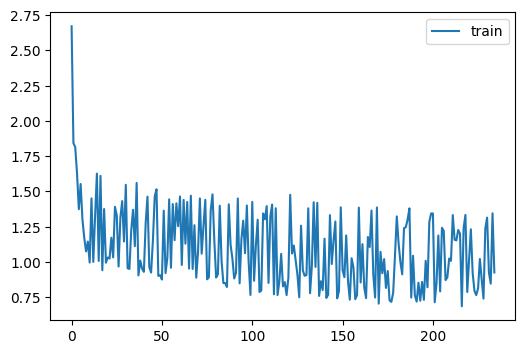

Fit 1 in: 24.89s, setup: 0.00s, 22.96 ± 0.00s per epoch, 0.02 ± 0.00s per batch
lam tensor([0.09516283], device='cuda:0')
-0.008551293984055519
tensor([-1.19561470, -0.22153053, -1.68820953, -0.08950519,  1.88223028,  1.15275347, -2.57176828, -0.68397009, -0.75691664,  0.34121916])


In [ ]:
rng.set_seed(1)
learn1 = run(
    get_model9(nn.SiLU, norm=nn.BatchNorm2d), leaky=0.0003, 
    base_lr=1e-2, epochs=1, 
    cbs=[], 
    train_cb=MixUp4CB(0.4, use_prev=False, eta=None, per_batch=True, loss_func=mce, label_smoothing=0.1), fit=True)
print('lam', learn1.mixup.lam)
print(learn1.model(xb.to('cuda')).mean().item())
B=torch.get_rng_state().clone()
print(torch.randn([10]))

Batch size 256
tensor([-0.32495922,  0.12167471,  2.01532531])
tensor([9, 6, 9, 9, 3, 4, 7, 4, 9, 8, 4, 1, 8, 7, 6, 0, 8, 7, 1, 6, 0, 7, 7, 6, 6, 3, 1, 7, 0, 7, 9, 7, 4, 6, 7, 4, 3, 8, 2, 5, 5, 8, 2, 2,
        3, 5, 0, 1, 8, 1, 7, 0, 6, 6, 1, 7, 8, 6, 7, 3, 9, 7, 9, 7, 9, 7, 7, 5, 8, 6, 6, 2, 6, 4, 8, 6, 3, 4, 7, 9, 3, 4, 9, 5, 6, 6, 5, 7,
        6, 7, 2, 0, 5, 5, 5, 0, 4, 1, 9, 1, 0, 3, 2, 7, 6, 6, 1, 7, 9, 7, 1, 9, 1, 3, 6, 5, 3, 0, 0, 0, 1, 8, 1, 9, 3, 8, 0, 4, 7, 2, 9, 1,
        2, 4, 5, 0, 0, 0, 2, 5, 4, 2, 9, 9, 2, 8, 6, 0, 7, 4, 4, 2, 0, 7, 6, 0, 6, 3, 4, 1, 3, 9, 8, 5, 6, 2, 6, 2, 7, 9, 3, 4, 4, 2, 5, 6,
        7, 5, 4, 9, 2, 5, 7, 5, 2, 9, 2, 7, 0, 5, 4, 2, 4, 3, 5, 0, 5, 9, 1, 3, 6, 4, 0, 9, 9, 1, 7, 1, 1, 1, 0, 8, 5, 1, 1, 5, 3, 0, 2, 3,
        4, 1, 8, 6, 1, 3, 5, 6, 5, 6, 0, 0, 5, 5, 4, 0, 7, 7, 4, 8, 0, 1, 6, 9, 9, 1, 2, 5, 2, 3, 0, 5, 1, 5, 8, 5])
Using seed 1


accuracy,loss,epoch,train
0.493,0.814,0,train
0.911,0.329,0,eval


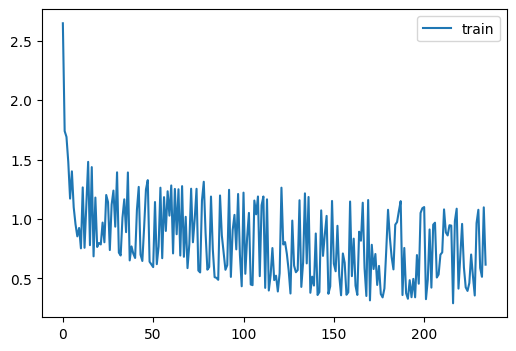

/home/piotr/miniconda3/envs/miniai/lib/python3.10/site-packages/numpy/core/shape_base.py:65: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  ary = asanyarray(ary)
/home/piotr/miniconda3/envs/miniai/lib/python3.10/site-packages/numpy/core/shape_base.py:65: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  ary = asanyarray(ary)


Fit 1 in: 24.82s, setup: 0.00s, 22.90 ± 0.00s per epoch, 0.02 ± 0.00s per batch
lam tensor([0.09516283], device='cuda:0')
-0.01794198714196682
tensor([-1.19561470, -0.22153053, -1.68820953, -0.08950519,  1.88223028,  1.15275347, -2.57176828, -0.68397009, -0.75691664,  0.34121916])


In [ ]:
rng.set_seed(1)
learn1 = run(
    get_model9(nn.SiLU, norm=nn.BatchNorm2d), leaky=0.0003, 
    base_lr=1e-2, epochs=1, 
    cbs=[], 
    train_cb=MixUpCB(0.4, label_smoothing=0.1), fit=True)
print('lam', learn1.mixup[-2])
print(learn1.model(xb.to('cuda')).mean().item()),
B=torch.get_rng_state().clone()
print(torch.randn([10]))

### CMP 20 epochs

Batch size 256
tensor([-0.32495922,  0.12167471,  2.01532531])
tensor([9, 6, 9, 9, 3, 4, 7, 4, 9, 8, 4, 1, 8, 7, 6, 0, 8, 7, 1, 6, 0, 7, 7, 6, 6, 3, 1, 7, 0, 7, 9, 7, 4, 6, 7, 4, 3, 8, 2, 5, 5, 8, 2, 2,
        3, 5, 0, 1, 8, 1, 7, 0, 6, 6, 1, 7, 8, 6, 7, 3, 9, 7, 9, 7, 9, 7, 7, 5, 8, 6, 6, 2, 6, 4, 8, 6, 3, 4, 7, 9, 3, 4, 9, 5, 6, 6, 5, 7,
        6, 7, 2, 0, 5, 5, 5, 0, 4, 1, 9, 1, 0, 3, 2, 7, 6, 6, 1, 7, 9, 7, 1, 9, 1, 3, 6, 5, 3, 0, 0, 0, 1, 8, 1, 9, 3, 8, 0, 4, 7, 2, 9, 1,
        2, 4, 5, 0, 0, 0, 2, 5, 4, 2, 9, 9, 2, 8, 6, 0, 7, 4, 4, 2, 0, 7, 6, 0, 6, 3, 4, 1, 3, 9, 8, 5, 6, 2, 6, 2, 7, 9, 3, 4, 4, 2, 5, 6,
        7, 5, 4, 9, 2, 5, 7, 5, 2, 9, 2, 7, 0, 5, 4, 2, 4, 3, 5, 0, 5, 9, 1, 3, 6, 4, 0, 9, 9, 1, 7, 1, 1, 1, 0, 8, 5, 1, 1, 5, 3, 0, 2, 3,
        4, 1, 8, 6, 1, 3, 5, 6, 5, 6, 0, 0, 5, 5, 4, 0, 7, 7, 4, 8, 0, 1, 6, 9, 9, 1, 2, 5, 2, 3, 0, 5, 1, 5, 8, 5])
Using seed 1


accuracy,loss,epoch,train
0.490,0.897,0,train
0.881,0.487,0,eval
0.509,0.787,1,train
0.894,0.372,1,eval
0.528,0.696,2,train
0.914,0.316,2,eval
0.511,0.660,3,train
0.916,0.303,3,eval
0.476,0.614,4,train
0.923,0.277,4,eval


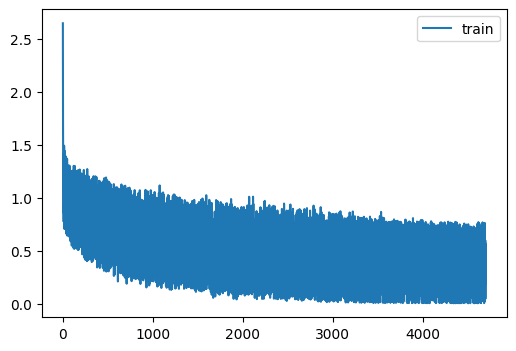

Fit 20 in: 503.60s, setup: 0.00s, 23.29 ± 0.16s per epoch, 0.02 ± 0.00s per batch
lam tensor([0.78671920], device='cuda:0')
0.20380337536334991
tensor([-1.71781194, -0.51013136, -0.28861845,  0.72152680,  0.83603626, -1.98357928,  1.23935509, -0.66814113, -0.66870362,  0.49368286])


In [ ]:
rng.set_seed(1)
learn1 = run(
    get_model9(nn.SiLU, norm=nn.BatchNorm2d), leaky=0.0003, 
    base_lr=1e-2, epochs=20, 
    cbs=[], 
    train_cb=MixUpCB(0.4, label_smoothing=0.1), fit=True)
print('lam', learn1.mixup[-2])
print(learn1.model(xb.to('cuda')).mean().item()),
B=torch.get_rng_state().clone()
print(torch.randn([10]))

Batch size 256
tensor([-0.32495922,  0.12167471,  2.01532531])
tensor([9, 6, 9, 9, 3, 4, 7, 4, 9, 8, 4, 1, 8, 7, 6, 0, 8, 7, 1, 6, 0, 7, 7, 6, 6, 3, 1, 7, 0, 7, 9, 7, 4, 6, 7, 4, 3, 8, 2, 5, 5, 8, 2, 2,
        3, 5, 0, 1, 8, 1, 7, 0, 6, 6, 1, 7, 8, 6, 7, 3, 9, 7, 9, 7, 9, 7, 7, 5, 8, 6, 6, 2, 6, 4, 8, 6, 3, 4, 7, 9, 3, 4, 9, 5, 6, 6, 5, 7,
        6, 7, 2, 0, 5, 5, 5, 0, 4, 1, 9, 1, 0, 3, 2, 7, 6, 6, 1, 7, 9, 7, 1, 9, 1, 3, 6, 5, 3, 0, 0, 0, 1, 8, 1, 9, 3, 8, 0, 4, 7, 2, 9, 1,
        2, 4, 5, 0, 0, 0, 2, 5, 4, 2, 9, 9, 2, 8, 6, 0, 7, 4, 4, 2, 0, 7, 6, 0, 6, 3, 4, 1, 3, 9, 8, 5, 6, 2, 6, 2, 7, 9, 3, 4, 4, 2, 5, 6,
        7, 5, 4, 9, 2, 5, 7, 5, 2, 9, 2, 7, 0, 5, 4, 2, 4, 3, 5, 0, 5, 9, 1, 3, 6, 4, 0, 9, 9, 1, 7, 1, 1, 1, 0, 8, 5, 1, 1, 5, 3, 0, 2, 3,
        4, 1, 8, 6, 1, 3, 5, 6, 5, 6, 0, 0, 5, 5, 4, 0, 7, 7, 4, 8, 0, 1, 6, 9, 9, 1, 2, 5, 2, 3, 0, 5, 1, 5, 8, 5])
Using seed 1


accuracy,loss,epoch,train
0.819,1.127,0,train
0.892,0.507,0,eval
0.844,1.056,1,train
0.901,0.410,1,eval
0.853,1.009,2,train
0.910,0.401,2,eval
0.857,0.998,3,train
0.924,0.328,3,eval
0.860,0.966,4,train
0.915,0.388,4,eval


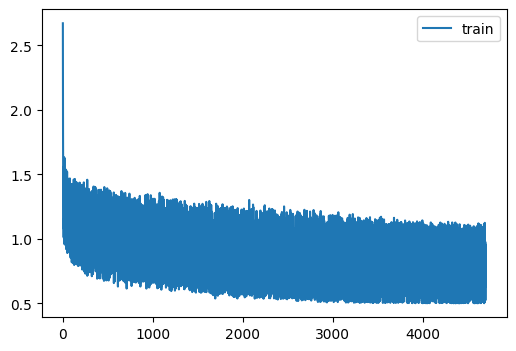

Fit 20 in: 506.34s, setup: 0.00s, 23.42 ± 0.08s per epoch, 0.02 ± 0.00s per batch
lam tensor([0.78671920], device='cuda:0')
0.04999415948987007
tensor([-1.71781194, -0.51013136, -0.28861845,  0.72152680,  0.83603626, -1.98357928,  1.23935509, -0.66814113, -0.66870362,  0.49368286])


In [ ]:
rng.set_seed(1)
learn1 = run(
    get_model9(nn.SiLU, norm=nn.BatchNorm2d), leaky=0.0003, 
    base_lr=1e-2, epochs=20, 
    cbs=[], 
    train_cb=MixUp4CB(0.4, use_prev=False, eta=None, per_batch=True, loss_func=mce, label_smoothing=0.1), fit=True)
print('lam', learn1.mixup.lam)
print(learn1.model(xb.to('cuda')).mean().item())
B=torch.get_rng_state().clone()
print(torch.randn([10]))

Batch size 256
tensor([-0.32495922,  0.12167471,  2.01532531])
tensor([9, 6, 9, 9, 3, 4, 7, 4, 9, 8, 4, 1, 8, 7, 6, 0, 8, 7, 1, 6, 0, 7, 7, 6, 6, 3, 1, 7, 0, 7, 9, 7, 4, 6, 7, 4, 3, 8, 2, 5, 5, 8, 2, 2,
        3, 5, 0, 1, 8, 1, 7, 0, 6, 6, 1, 7, 8, 6, 7, 3, 9, 7, 9, 7, 9, 7, 7, 5, 8, 6, 6, 2, 6, 4, 8, 6, 3, 4, 7, 9, 3, 4, 9, 5, 6, 6, 5, 7,
        6, 7, 2, 0, 5, 5, 5, 0, 4, 1, 9, 1, 0, 3, 2, 7, 6, 6, 1, 7, 9, 7, 1, 9, 1, 3, 6, 5, 3, 0, 0, 0, 1, 8, 1, 9, 3, 8, 0, 4, 7, 2, 9, 1,
        2, 4, 5, 0, 0, 0, 2, 5, 4, 2, 9, 9, 2, 8, 6, 0, 7, 4, 4, 2, 0, 7, 6, 0, 6, 3, 4, 1, 3, 9, 8, 5, 6, 2, 6, 2, 7, 9, 3, 4, 4, 2, 5, 6,
        7, 5, 4, 9, 2, 5, 7, 5, 2, 9, 2, 7, 0, 5, 4, 2, 4, 3, 5, 0, 5, 9, 1, 3, 6, 4, 0, 9, 9, 1, 7, 1, 1, 1, 0, 8, 5, 1, 1, 5, 3, 0, 2, 3,
        4, 1, 8, 6, 1, 3, 5, 6, 5, 6, 0, 0, 5, 5, 4, 0, 7, 7, 4, 8, 0, 1, 6, 9, 9, 1, 2, 5, 2, 3, 0, 5, 1, 5, 8, 5])
Using seed 1


accuracy,loss,epoch,train
0.813,1.151,0,train
0.884,0.477,0,eval
0.847,1.045,1,train
0.893,0.423,1,eval
0.847,1.017,2,train
0.904,0.362,2,eval
0.859,0.986,3,train
0.914,0.341,3,eval
0.868,0.964,4,train
0.922,0.324,4,eval


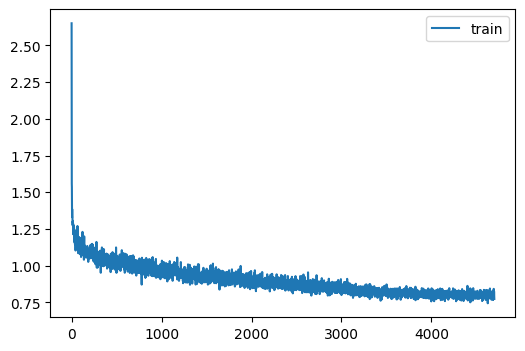

Fit 20 in: 503.81s, setup: 0.00s, 23.28 ± 0.17s per epoch, 0.02 ± 0.00s per batch
lam tensor([    0.52552468,     0.02442432,     0.17364037,     0.67338437,     0.18108995,     0.99775034,     0.96209472,     0.92988640,
            0.17557794,     0.41593814,     0.04615306,     0.06022141,     0.93450367,     0.39759177,     0.00000747,     0.26552776,
            0.72831488,     0.01831994,     0.91011590,     0.08316126,     0.86101234,     0.99996334,     0.35128859,     0.99182445,
            0.17228632,     0.33321953,     0.18648113,     0.98342741,     0.00058535,     0.88880467,     0.99785507,     0.63015711,
            0.91072559,     0.95543140,     0.95421767,     0.01017770,     0.37351432,     0.65680587,     0.97772688,     0.20902403,
            0.65236086,     0.28446636,     0.00041902,     0.39774770,     0.98739880,     0.80271006,     0.99829924,     0.06359376,
            0.98535454,     0.85125655,     0.00078182,     0.13301371,     0.99955899,     0.8078

In [ ]:
rng.set_seed(1)
learn1 = run(
    get_model9(nn.SiLU, norm=nn.BatchNorm2d), leaky=0.0003, 
    base_lr=1e-2, epochs=20, 
    cbs=[], 
    train_cb=MixUp4CB(0.4, use_prev=True, eta=None, per_batch=False, loss_func=mce, label_smoothing=0.1), fit=True)
print('lam', learn1.mixup.lam)
print(learn1.model(xb.to('cuda')).mean().item())
B=torch.get_rng_state().clone()
print(torch.randn([10]))

# Dynamic mixup loss function

## Authors impl


In [ ]:
#https://github.com/Westlake-AI/openmixup/blob/c042813ee0af577d365f0e13b13a4c8486d6e8f7/openmixup/models/losses/cross_entropy_loss.py#L83

def weight_reduce_loss(loss, weight=None, reduction='mean', avg_factor=None):
    """Apply element-wise weight and reduce loss.
    Args:
        loss (Tensor): Element-wise loss tensor.
        weight (Tensor): Element-wise weights.
        reduction (str): Same as built-in losses of PyTorch. Options are "none",
            "mean" and "sum".
        avg_factor (float): Avarage factor when computing the mean of losses.
    Returns:
        Tensor: Processed loss values.
    """
    # if weight is specified, apply element-wise weight
    if weight is not None:
        loss = loss * weight

    reduction_enum = F._Reduction.get_enum(reduction)
    # if avg_factor is not specified, just reduce the loss
    if avg_factor is None:
        # none: 0, elementwise_mean:1, sum: 2
        if reduction_enum == 1:
            loss = loss.mean()
        elif reduction_enum == 2:
            loss = loss.sum()
    else:
        # if reduction is 'mean', then average the loss by avg_factor
        if reduction_enum == 1:
            loss = loss.sum() / avg_factor
        # if reduction is 'none', then do nothing; otherwise raise an error
        elif reduction != 0:
            raise ValueError('avg_factor can not be used with reduction="sum"')
    return loss

def soft_mix_cross_entropy(pred,
                           label,
                           weight=None,
                           reduction='mean',
                           class_weight=None,
                           avg_factor=None,
                           eta_weight=None,
                           eps_smooth=1e-3,
                           verbose=False,
                           **kwargs):
    r"""Calculate the Soft Decoupled Mixup CrossEntropy loss using softmax
        The label can be float mixup label (class-wise sum to 1, k-mixup, k>=2).
       *** Warnning: this mixup and label-smoothing cannot be set simultaneously ***
    Decoupled Mixup for Data-efficient Learning. In arXiv, 2022.
    <https://arxiv.org/abs/2203.10761>
    Args:
        pred (torch.Tensor): The prediction with shape (N, C), C is the number
            of classes.
        label (torch.Tensor): The gt label of the prediction with shape (N, C).
            When using "mixup", the label can be float (mixup one-hot label).
        weight (torch.Tensor, optional): Sample-wise loss weight.
        reduction (str): The method used to reduce the loss.
        avg_factor (int, optional): Average factor that is used to average
            the loss. Defaults to None.
        class_weight (torch.Tensor, optional): The weight for each class with
            shape (C), C is the number of classes. Default None.
        eta_weight (list): Reweight the global loss in mixup cls loss as,
            loss = loss_local + eta_weight[i] * loss_global[i]. Default to None.
        eps_smooth (float): If using label smoothing, we assume eps < lam < 1-eps.
    Returns:
        torch.Tensor: The calculated loss
    """
    # *** Assume k-mixup in C classes, k >= 2 and k << C ***
    # step 1: remove labels have less than k-hot (mixed between the
    #    same class will result in the original onehot)
    _eps = max(1e-3, eps_smooth)  # assuming _eps < lam < 1-_eps
    mask_one = (label > _eps).sum(dim=-1)
    mix_num = max(mask_one)
    mask_one = mask_one >= mix_num
    if mask_one.sum() < label.size(0):
        pred_one = pred[mask_one==False, :]
        label_one = label[mask_one==False, :]
        pred = pred[mask_one, :]
        label = label[mask_one, :]
        weight_one = None
        if weight is not None:
            weight_one = weight[mask_one==False, ...].float()
            weight = weight[mask_one, ...].float()
        if verbose: print(f"pred_one: {mask_one=} {pred_one=}")
    else:
        if weight is not None:
            weight = weight.float()
        pred_one, label_one, weight_one = None, None, None
        if verbose: print(f"no pred_one {mask_one=}")
    # step 2: select k-mixup for the local and global
    bs, cls_num = label.size()  # N, C
    assert isinstance(eta_weight, list)
    # local: between k classes
    mask_lam_k = label > _eps  # [N, N], top k is true
    lam_k = label[0, label[0, :] > _eps]  # [k,] k-mix relevant classes

    # local: original mixup CE loss between C classes
    loss = -label * F.log_softmax(pred, dim=-1)  # [N, N]
    if class_weight is not None:
        loss *= class_weight
    loss = loss.sum(dim=-1)  # reduce class

    # global: between lam_i and C-k classes
    if len(set(lam_k.cpu().numpy())) == lam_k.size(0) and lam_k.size(0) > 1:
        if verbose: print("calculating global loss for", lam_k, 'loss so far', loss)
        # *** trivial solution: lam=0.5, lam=1.0 ***
        assert len(eta_weight) == lam_k.size(0), \
            "eta weight={}, lam_k={}".format(eta_weight, lam_k)
        for i in range(lam_k.size(0)):
            # selected (C-k+1), except lam_k[j], where j!=i (k-1)
            mask_lam_i = (label == lam_k[i]) | ~mask_lam_k  # [N, N]
            pred_lam_i  = pred.reshape([1, bs, -1])[:, mask_lam_i].reshape(
                [-1, cls_num+1-lam_k.size(0)])  # [N, C-k+1]
            label_lam_i = label.reshape([1, bs, -1])[:, mask_lam_i].reshape(
                [-1, cls_num+1-lam_k.size(0)])  # [N, C-k+1]
            # convert to onehot
            label_lam_i = (label_lam_i > 0).type(torch.float)
            # element-wise losses
            loss_global = -label_lam_i * F.log_softmax(pred_lam_i, dim=-1)  # [N, C-1]
            if class_weight is not None:
                loss_global *= class_weight
            # eta reweight
            if verbose: print(f"global loss: {loss_global.sum(dim=-1)} for {lam_k[i]}")
            loss += eta_weight[i] * loss_global.sum(dim=-1)  # reduce class
    # apply weight and do the reduction
    loss = weight_reduce_loss(
        loss, weight=weight, reduction=reduction, avg_factor=avg_factor)

    # step 3: original soft CE loss
    if label_one is not None:
        loss_one = -label_one * F.log_softmax(pred_one, dim=-1)
        if class_weight is not None:
            loss_one *= class_weight
        loss_one = loss_one.sum(dim=-1)  # reduce class
        if verbose: print(f"loss_one: {loss_one=} {loss=}")

        loss_one = weight_reduce_loss(
            loss_one, weight=weight_one, reduction=reduction, avg_factor=avg_factor)
        loss += loss_one or 0.0

    return loss


## Our impl

In [ ]:
set_seed(1)
b = 20
a = 10.
x1 = tensor([[1,  1, a, 1],
             [a,  1, 1, 1]]).float()
x2 = tensor([[1,  b, 1, 1],
             [1,  1, 1, b]]).float()
y1 = (x1).argmax(-1)
y2 = (x2).argmax(-1) 

print(y1, y2)
r = mixup_data((x1,y1), (x2,y2), classes=4, permute_1=False,)


tensor([2, 0]) tensor([1, 3])


In [ ]:
(0.73 * b+ 0.27*1), 0.2689*a+ 0.73*1

(14.87, 3.4189999999999996)

In [ ]:
# lets construct the mask manually
maskb = r.mixed_x>14
maska = (r.mixed_x>2) & (~maskb)
maska

tensor([[False, False,  True, False],
        [ True, False, False, False]])

In [ ]:
pred=r.mixed_x[~maskb].reshape(2, -1) 
lbl=maska[~maskb].reshape(2, -1).float()
print(pred,lbl)
F.cross_entropy(pred, lbl, reduction='mean').item()

tensor([[1.00000000, 3.41863847, 1.00000000],
        [2.84580517, 1.00000000, 1.00000000]]) tensor([[0., 1., 0.],
        [1., 0., 0.]])


0.21916639804840088

In [ ]:
def ce_masked(preds, y, ignored_y, **kwargs):
    """
    y - one hot encoded label
    ingored_y - one hot encloded of ignored class
    """
    N, C = preds.shape
    mask = ignored_y==0
    mpreds = preds[mask].reshape(N, C-1) # to fail early
    my = y[mask].float().reshape(N, C-1)
    return F.cross_entropy(mpreds, my, **kwargs)

ce_masked(r.mixed_x, r.y2, r.y1).item()

0.21916639804840088

In [ ]:
ce_masked(r.mixed_x, r.y1, r.y1).item() + ce_masked(r.mixed_y, r.y2, r.y2).item() 

-0.0

In [ ]:
def dmce(preds, r, eta=0.1, verbose=False, **kw): 
    mce = F.cross_entropy(preds, r.mixed_y, **kw) 
    dmce1 = ce_masked(preds, r.y1, r.y2, **kw)
    dmce2 = ce_masked(preds, r.y2, r.y1, **kw)
    if verbose: print(f"{mce} + {eta}*{dmce1} + {eta}*{dmce2}")
    return (mce + eta*dmce1 + eta*dmce2)

def dmce_orig(preds, r, eta=[0.1,0.1], verbose=False, **kw):
    return soft_mix_cross_entropy(preds, r.mixed_y, eta_weight=eta, verbose=verbose)                

In [ ]:
rng_seed.set_new(1)
b = 20
a = 11.
x1 = tensor([[1,  1, a, 1],
             [a,  1, 1, 1]]).float()
x2 = tensor([[1,  b, 1, 1],
             [1,  1, 1, b]]).float()
y1 = (x1).argmax(-1)
y2 = (x2).argmax(-1) 

print(y1, y2)
r = mixup_data((x1,y1), (x2,y2), classes=4, permute_1=False, sampler=lambda x: torch.tensor([0.3, 1.0]))

dmce_orig(r.mixed_x, r, verbose=True), dmce(r.mixed_x, r, verbose=True)

tensor([2, 0]) tensor([1, 3])
pred_one: mask_one=tensor([ True, False]) pred_one=tensor([[ 1.,  1.,  1., 20.]])
calculating global loss for tensor([0.30000001, 0.69999999]) loss so far tensor([0.63244051])
global loss: tensor([0.00666964]) for 0.30000001192092896
global loss: tensor([0.00182200]) for 0.699999988079071
loss_one: loss_one=tensor([0.]) loss=tensor(0.63328969)
0.3162202537059784 + 0.1*0.0033348205033689737 + 0.1*0.5502171516418457


(tensor(0.63328969), tensor(0.37157544))

In [ ]:
r.mixed_y

tensor([[0.00000000, 0.30000001, 0.69999999, 0.00000000],
        [0.00000000, 0.00000000, 0.00000000, 1.00000000]])

### Tests

Batch size 256
tensor([-0.32495922,  0.12167471,  2.01532531])
tensor([9, 6, 9, 9, 3, 4, 7, 4, 9, 8, 4, 1, 8, 7, 6, 0, 8, 7, 1, 6, 0, 7, 7, 6, 6, 3, 1, 7, 0, 7, 9, 7, 4, 6, 7, 4, 3, 8, 2, 5, 5, 8, 2, 2,
        3, 5, 0, 1, 8, 1, 7, 0, 6, 6, 1, 7, 8, 6, 7, 3, 9, 7, 9, 7, 9, 7, 7, 5, 8, 6, 6, 2, 6, 4, 8, 6, 3, 4, 7, 9, 3, 4, 9, 5, 6, 6, 5, 7,
        6, 7, 2, 0, 5, 5, 5, 0, 4, 1, 9, 1, 0, 3, 2, 7, 6, 6, 1, 7, 9, 7, 1, 9, 1, 3, 6, 5, 3, 0, 0, 0, 1, 8, 1, 9, 3, 8, 0, 4, 7, 2, 9, 1,
        2, 4, 5, 0, 0, 0, 2, 5, 4, 2, 9, 9, 2, 8, 6, 0, 7, 4, 4, 2, 0, 7, 6, 0, 6, 3, 4, 1, 3, 9, 8, 5, 6, 2, 6, 2, 7, 9, 3, 4, 4, 2, 5, 6,
        7, 5, 4, 9, 2, 5, 7, 5, 2, 9, 2, 7, 0, 5, 4, 2, 4, 3, 5, 0, 5, 9, 1, 3, 6, 4, 0, 9, 9, 1, 7, 1, 1, 1, 0, 8, 5, 1, 1, 5, 3, 0, 2, 3,
        4, 1, 8, 6, 1, 3, 5, 6, 5, 6, 0, 0, 5, 5, 4, 0, 7, 7, 4, 8, 0, 1, 6, 9, 9, 1, 2, 5, 2, 3, 0, 5, 1, 5, 8, 5])
Using seed 1


accuracy,loss,epoch,train
0.798,0.921,0,train
0.866,0.452,0,eval
0.816,0.742,1,train
0.900,0.308,1,eval
0.848,0.650,2,train
0.916,0.276,2,eval
0.857,0.620,3,train
0.936,0.208,3,eval
0.880,0.531,4,train
0.939,0.212,4,eval


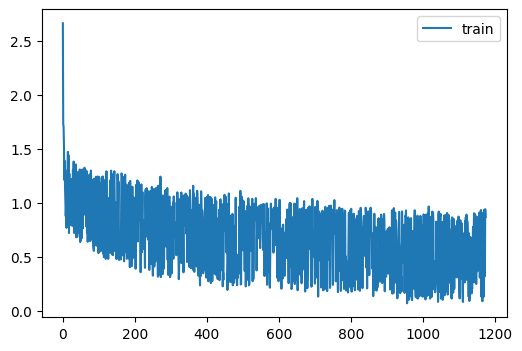

Fit 5 in: 125.56s, setup: 0.00s, 23.21 ± 0.06s per epoch, 0.02 ± 0.00s per batch


In [ ]:
rng.previous()
learn = run(
    get_model9(nn.SiLU, norm=nn.BatchNorm2d), leaky=0.0003, 
    base_lr=2e-2, epochs=5, 
    cbs=[], 
    train_cb=MixUp4CB(0.5, use_prev=False, eta=None, per_batch=True, loss_func=mce, label_smoothing=0.0))

In [ ]:
# learn3 = run(
#     get_model9(nn.SiLU, norm=nn.BatchNorm2d), leaky=0.0003, 
#     base_lr=1e-2, epochs=1, 
#     cbs=[], 
#     train_cb=MixUpCB(0.4), dls=dls, fit=False)
# epochs = 1
# lr = 1e-2
# tmax = epochs * len(dls.train)
# sched = partial(lr_scheduler.OneCycleLR, max_lr=lr, total_steps=tmax)
# xtra = [BatchSchedCB(sched), MixUpCB(0.4)] 

# learn3.cbs = cbs+xtra
# print(learn1.cbs)
# learn3.fit(1)
# print(learn3.model(xb).mean().item())

In [ ]:
learn1.batch[1]

In [ ]:
learn2.batch[1]

In [ ]:
learn2.

In [ ]:
set_seed(1)
metrics = MetricsCB(accuracy=MulticlassAccuracy())
cbs = [DeviceCB(), metrics, ProgressCB()] 
act_gr = nn.SiLU
iw = partial(init_weights, leaky=0.0003)
epochs = 5
lr = 1e-2
tmax = epochs * len(dls.train)
sched = partial(lr_scheduler.OneCycleLR, max_lr=lr, total_steps=tmax)
xtra = [BatchSchedCB(sched), MixUp4CB(0.4, use_prev=False, eta=None, per_batch=True, loss_func=mce)] 
model = get_model9(act_gr, norm=nn.BatchNorm2d).apply(iw)
learn = Learner(model, dls, F.cross_entropy, lr=lr, cbs=cbs+xtra, opt_func=optim.AdamW)
learn.fit(epochs, cbs=TimeItCB())

### [93.8] MCE, single_lam

Batch size 256
tensor([-1.60023975,  0.09648570, -0.04759153])
tensor([8, 7, 4, 5, 5, 4, 6, 6, 7, 4, 5, 5, 9, 3, 8, 6, 4, 9, 7, 1, 7, 3, 0, 0, 7, 0, 3, 6, 8, 6, 8, 1, 9, 1, 9, 5, 8, 5, 9, 4, 1, 0, 0, 5,
        8, 3, 0, 2, 9, 9, 9, 7, 9, 2, 3, 9, 4, 4, 7, 8, 6, 1, 9, 8, 2, 7, 8, 4, 2, 5, 3, 3, 8, 5, 0, 4, 5, 6, 1, 2, 0, 7, 4, 5, 7, 9, 3, 4,
        5, 1, 6, 4, 0, 3, 2, 0, 7, 6, 7, 1, 1, 3, 9, 8, 2, 3, 0, 4, 9, 2, 8, 9, 8, 2, 7, 2, 9, 7, 0, 7, 1, 8, 7, 6, 4, 6, 6, 9, 2, 3, 4, 3,
        8, 5, 9, 2, 0, 8, 3, 5, 3, 5, 4, 0, 1, 9, 7, 1, 9, 5, 1, 8, 2, 9, 1, 2, 6, 2, 6, 2, 9, 1, 6, 5, 0, 1, 2, 6, 6, 0, 6, 9, 1, 7, 8, 3,
        9, 6, 5, 6, 6, 4, 9, 1, 4, 2, 8, 3, 0, 6, 9, 7, 1, 5, 8, 1, 5, 0, 5, 4, 2, 9, 3, 5, 6, 9, 7, 9, 6, 5, 8, 0, 7, 0, 4, 4, 6, 9, 6, 2,
        6, 8, 3, 4, 5, 6, 1, 0, 9, 8, 3, 2, 6, 6, 3, 7, 5, 5, 1, 5, 0, 9, 8, 1, 9, 3, 8, 6, 4, 7, 5, 4, 1, 5, 6, 5])
Using seed 1


accuracy,loss,epoch,train
0.809,0.876,0,train
0.850,0.471,0,eval
0.827,0.709,1,train
0.848,0.437,1,eval
0.848,0.632,2,train
0.914,0.301,2,eval
0.867,0.586,3,train
0.932,0.213,3,eval
0.881,0.529,4,train
0.939,0.217,4,eval


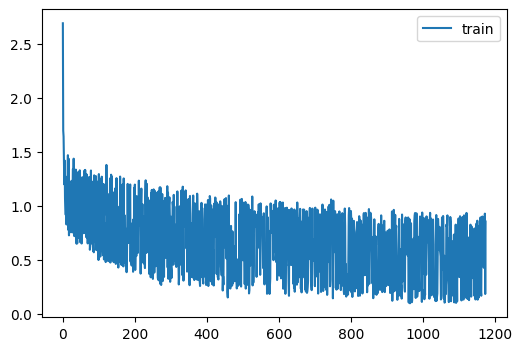

Fit 5 in: 126.35s, setup: 0.00s, 23.37 ± 0.06s per epoch, 0.02 ± 0.00s per batch


In [ ]:
rng.previous()
learn = run(
    get_model9(nn.SiLU, norm=nn.BatchNorm2d), leaky=0.0003, 
    base_lr=2e-2, epochs=5, 
    cbs=[], 
    train_cb=MixUp4CB(0.4, use_prev=True, eta=None, per_batch=True, loss_func=mce, label_smoothing=0.0))

### [92.1] DMCE copy, per_batch eta 0.1, 0.1

Batch size 256
tensor([ 0.52630275,  0.50753367, -0.22056779])
tensor([2, 5, 7, 6, 2, 2, 0, 4, 3, 6, 2, 8, 7, 4, 3, 7, 3, 0, 7, 1, 3, 7, 9, 8, 2, 1, 5, 4, 9, 6, 0, 3, 8, 0, 8, 9, 2, 8, 2, 3, 5, 9, 0, 8,
        2, 5, 0, 6, 4, 2, 8, 2, 7, 9, 4, 0, 8, 7, 1, 3, 2, 6, 8, 0, 0, 7, 7, 8, 2, 5, 0, 9, 4, 1, 1, 2, 2, 2, 8, 8, 1, 4, 3, 2, 2, 8, 9, 7,
        7, 9, 8, 7, 7, 7, 5, 8, 1, 0, 5, 3, 3, 4, 3, 1, 5, 1, 2, 8, 1, 1, 9, 3, 4, 5, 9, 3, 6, 2, 6, 3, 1, 1, 9, 8, 6, 7, 4, 2, 1, 6, 3, 1,
        9, 4, 0, 2, 8, 3, 7, 2, 1, 6, 3, 5, 6, 1, 2, 0, 8, 1, 1, 1, 0, 6, 0, 0, 0, 1, 5, 7, 5, 1, 0, 5, 4, 5, 6, 5, 6, 6, 7, 4, 6, 5, 6, 8,
        2, 4, 3, 0, 1, 3, 8, 9, 6, 4, 3, 8, 6, 6, 8, 0, 5, 1, 1, 2, 8, 7, 4, 2, 4, 3, 9, 4, 2, 4, 0, 3, 9, 6, 8, 5, 3, 5, 7, 9, 4, 2, 9, 2,
        7, 9, 2, 9, 6, 6, 7, 4, 3, 6, 2, 9, 2, 0, 5, 7, 1, 7, 9, 3, 1, 2, 4, 3, 5, 6, 2, 1, 3, 0, 6, 2, 9, 9, 0, 5])
Using seed 1


accuracy,loss,epoch,train
0.753,1.836,0,train
0.824,0.516,0,eval
0.783,1.380,1,train
0.892,0.331,1,eval
0.814,1.150,2,train
0.894,0.309,2,eval
0.821,1.068,3,train
0.912,0.263,3,eval
0.841,0.927,4,train
0.921,0.235,4,eval


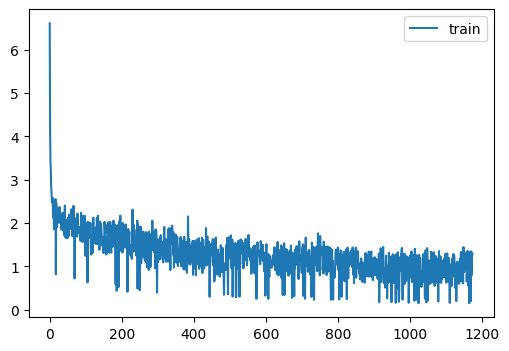

Fit 5 in: 145.80s, setup: 0.00s, 27.26 ± 0.08s per epoch, 0.05 ± 0.00s per batch


In [ ]:
rng.previous()
learn = run(
    get_model9(nn.SiLU, norm=nn.BatchNorm2d), leaky=0.0003, 
    base_lr=2e-2, epochs=5, 
    cbs=[], 
    train_cb=MixUp4CB(0.5, use_prev=True, eta=[0.1,0.1], per_batch=True, loss_func=dmce_c, label_smoothing=0.0))

### [93.6] DMCE (our), per_batch

Batch size 256
tensor([-1.60023975,  0.09648570, -0.04759153])
tensor([8, 7, 4, 5, 5, 4, 6, 6, 7, 4, 5, 5, 9, 3, 8, 6, 4, 9, 7, 1, 7, 3, 0, 0, 7, 0, 3, 6, 8, 6, 8, 1, 9, 1, 9, 5, 8, 5, 9, 4, 1, 0, 0, 5,
        8, 3, 0, 2, 9, 9, 9, 7, 9, 2, 3, 9, 4, 4, 7, 8, 6, 1, 9, 8, 2, 7, 8, 4, 2, 5, 3, 3, 8, 5, 0, 4, 5, 6, 1, 2, 0, 7, 4, 5, 7, 9, 3, 4,
        5, 1, 6, 4, 0, 3, 2, 0, 7, 6, 7, 1, 1, 3, 9, 8, 2, 3, 0, 4, 9, 2, 8, 9, 8, 2, 7, 2, 9, 7, 0, 7, 1, 8, 7, 6, 4, 6, 6, 9, 2, 3, 4, 3,
        8, 5, 9, 2, 0, 8, 3, 5, 3, 5, 4, 0, 1, 9, 7, 1, 9, 5, 1, 8, 2, 9, 1, 2, 6, 2, 6, 2, 9, 1, 6, 5, 0, 1, 2, 6, 6, 0, 6, 9, 1, 7, 8, 3,
        9, 6, 5, 6, 6, 4, 9, 1, 4, 2, 8, 3, 0, 6, 9, 7, 1, 5, 8, 1, 5, 0, 5, 4, 2, 9, 3, 5, 6, 9, 7, 9, 6, 5, 8, 0, 7, 0, 4, 4, 6, 9, 6, 2,
        6, 8, 3, 4, 5, 6, 1, 0, 9, 8, 3, 2, 6, 6, 3, 7, 5, 5, 1, 5, 0, 9, 8, 1, 9, 3, 8, 6, 4, 7, 5, 4, 1, 5, 6, 5])
Using seed 1


accuracy,loss,epoch,train
0.787,1.139,0,train
0.873,0.412,0,eval
0.810,0.898,1,train
0.868,0.369,1,eval
0.839,0.791,2,train
0.912,0.265,2,eval
0.850,0.739,3,train
0.934,0.209,3,eval
0.873,0.647,4,train
0.936,0.221,4,eval


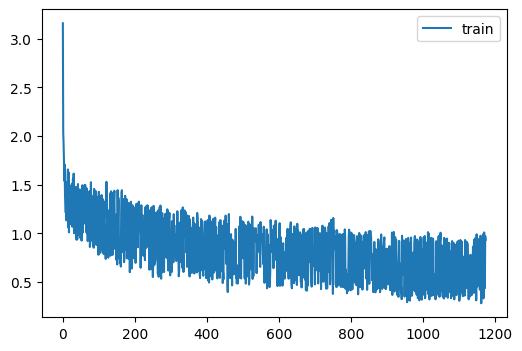

Fit 5 in: 127.97s, setup: 0.00s, 23.71 ± 0.05s per epoch, 0.04 ± 0.00s per batch


In [ ]:
rng.previous()
learn = run(
    get_model9(nn.SiLU, norm=nn.BatchNorm2d), leaky=0.0003, 
    base_lr=2e-2, epochs=5, 
    cbs=[], 
    train_cb=MixUp4CB(0.5, use_prev=True, eta=0.1, per_batch=True, loss_func=dmce, label_smoothing=0.0))

### [92.4] DMCE copy, per_batch eta[0.1,0.9]

Batch size 256
tensor([-1.60023975,  0.09648570, -0.04759153])
tensor([8, 7, 4, 5, 5, 4, 6, 6, 7, 4, 5, 5, 9, 3, 8, 6, 4, 9, 7, 1, 7, 3, 0, 0, 7, 0, 3, 6, 8, 6, 8, 1, 9, 1, 9, 5, 8, 5, 9, 4, 1, 0, 0, 5,
        8, 3, 0, 2, 9, 9, 9, 7, 9, 2, 3, 9, 4, 4, 7, 8, 6, 1, 9, 8, 2, 7, 8, 4, 2, 5, 3, 3, 8, 5, 0, 4, 5, 6, 1, 2, 0, 7, 4, 5, 7, 9, 3, 4,
        5, 1, 6, 4, 0, 3, 2, 0, 7, 6, 7, 1, 1, 3, 9, 8, 2, 3, 0, 4, 9, 2, 8, 9, 8, 2, 7, 2, 9, 7, 0, 7, 1, 8, 7, 6, 4, 6, 6, 9, 2, 3, 4, 3,
        8, 5, 9, 2, 0, 8, 3, 5, 3, 5, 4, 0, 1, 9, 7, 1, 9, 5, 1, 8, 2, 9, 1, 2, 6, 2, 6, 2, 9, 1, 6, 5, 0, 1, 2, 6, 6, 0, 6, 9, 1, 7, 8, 3,
        9, 6, 5, 6, 6, 4, 9, 1, 4, 2, 8, 3, 0, 6, 9, 7, 1, 5, 8, 1, 5, 0, 5, 4, 2, 9, 3, 5, 6, 9, 7, 9, 6, 5, 8, 0, 7, 0, 4, 4, 6, 9, 6, 2,
        6, 8, 3, 4, 5, 6, 1, 0, 9, 8, 3, 2, 6, 6, 3, 7, 5, 5, 1, 5, 0, 9, 8, 1, 9, 3, 8, 6, 4, 7, 5, 4, 1, 5, 6, 5])
Using seed 1


accuracy,loss,epoch,train
0.751,2.748,0,train
0.869,0.416,0,eval
0.768,2.026,1,train
0.889,0.370,1,eval
0.796,1.679,2,train
0.897,0.309,2,eval
0.802,1.508,3,train
0.923,0.240,3,eval
0.827,1.293,4,train
0.924,0.228,4,eval


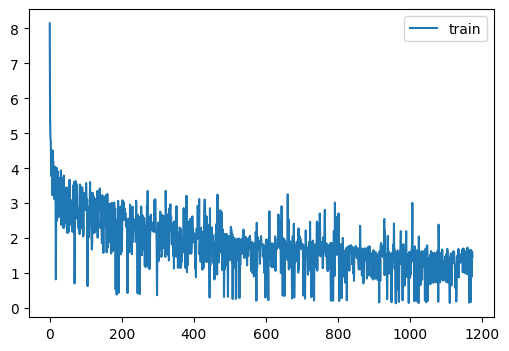

Fit 5 in: 146.14s, setup: 0.00s, 27.33 ± 0.15s per epoch, 0.05 ± 0.00s per batch


In [ ]:
rng.previous()
learn = run(
    get_model9(nn.SiLU, norm=nn.BatchNorm2d), leaky=0.0003, 
    base_lr=2e-2, epochs=5, 
    cbs=[], 
    train_cb=MixUp4CB(0.5, use_prev=True, eta=[0.1,0.9], per_batch=True, loss_func=dmce_c, label_smoothing=0.0))

### [93.9] DCME (our), per_sample

Batch size 256
tensor([-1.60023975,  0.09648570, -0.04759153])
tensor([8, 7, 4, 5, 5, 4, 6, 6, 7, 4, 5, 5, 9, 3, 8, 6, 4, 9, 7, 1, 7, 3, 0, 0, 7, 0, 3, 6, 8, 6, 8, 1, 9, 1, 9, 5, 8, 5, 9, 4, 1, 0, 0, 5,
        8, 3, 0, 2, 9, 9, 9, 7, 9, 2, 3, 9, 4, 4, 7, 8, 6, 1, 9, 8, 2, 7, 8, 4, 2, 5, 3, 3, 8, 5, 0, 4, 5, 6, 1, 2, 0, 7, 4, 5, 7, 9, 3, 4,
        5, 1, 6, 4, 0, 3, 2, 0, 7, 6, 7, 1, 1, 3, 9, 8, 2, 3, 0, 4, 9, 2, 8, 9, 8, 2, 7, 2, 9, 7, 0, 7, 1, 8, 7, 6, 4, 6, 6, 9, 2, 3, 4, 3,
        8, 5, 9, 2, 0, 8, 3, 5, 3, 5, 4, 0, 1, 9, 7, 1, 9, 5, 1, 8, 2, 9, 1, 2, 6, 2, 6, 2, 9, 1, 6, 5, 0, 1, 2, 6, 6, 0, 6, 9, 1, 7, 8, 3,
        9, 6, 5, 6, 6, 4, 9, 1, 4, 2, 8, 3, 0, 6, 9, 7, 1, 5, 8, 1, 5, 0, 5, 4, 2, 9, 3, 5, 6, 9, 7, 9, 6, 5, 8, 0, 7, 0, 4, 4, 6, 9, 6, 2,
        6, 8, 3, 4, 5, 6, 1, 0, 9, 8, 3, 2, 6, 6, 3, 7, 5, 5, 1, 5, 0, 9, 8, 1, 9, 3, 8, 6, 4, 7, 5, 4, 1, 5, 6, 5])
Using seed 1


accuracy,loss,epoch,train
0.788,1.144,0,train
0.874,0.412,0,eval
0.816,0.897,1,train
0.897,0.309,1,eval
0.838,0.796,2,train
0.919,0.244,2,eval
0.856,0.723,3,train
0.931,0.217,3,eval
0.879,0.660,4,train
0.939,0.197,4,eval


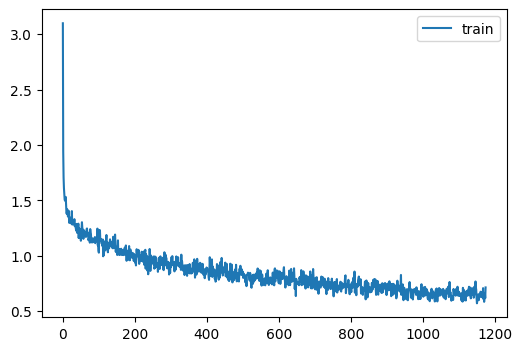

Fit 5 in: 128.15s, setup: 0.00s, 23.73 ± 0.04s per epoch, 0.04 ± 0.00s per batch


In [ ]:
rng.previous()
learn = run(
    get_model9(nn.SiLU, norm=nn.BatchNorm2d), leaky=0.0003, 
    base_lr=2e-2, epochs=5, 
    cbs=[], 
    train_cb=MixUp4CB(0.5, use_prev=True, eta=0.1, per_batch=False, loss_func=dmce, label_smoothing=0.0))


### [94.1] DCME (our), per_sample, lbl_smoothing

Batch size 256
tensor([-0.07165887,  0.09107433,  1.01960230])
tensor([9, 2, 5, 4, 2, 2, 2, 1, 6, 3, 9, 1, 1, 9, 6, 1, 3, 5, 8, 1, 7, 5, 6, 2, 8, 2, 9, 2, 6, 4, 5, 1, 1, 7, 3, 9, 6, 2, 8, 6, 4, 3, 7, 7,
        4, 8, 8, 2, 3, 8, 6, 6, 4, 2, 9, 4, 8, 5, 3, 2, 5, 7, 4, 3, 2, 0, 4, 0, 8, 4, 3, 0, 3, 2, 7, 2, 2, 9, 2, 4, 1, 4, 8, 7, 5, 5, 2, 1,
        1, 2, 6, 0, 3, 6, 2, 2, 3, 4, 9, 8, 6, 1, 7, 5, 8, 5, 5, 8, 7, 5, 3, 1, 9, 7, 9, 4, 5, 3, 7, 2, 9, 9, 2, 2, 3, 2, 3, 7, 4, 9, 1, 1,
        1, 6, 4, 3, 6, 3, 6, 0, 5, 7, 2, 0, 5, 9, 3, 5, 2, 9, 5, 0, 9, 2, 2, 0, 3, 0, 3, 3, 3, 6, 0, 9, 9, 2, 4, 6, 6, 5, 1, 9, 9, 6, 9, 6,
        5, 0, 0, 2, 4, 6, 9, 6, 9, 2, 3, 9, 7, 3, 0, 9, 9, 2, 1, 4, 9, 2, 6, 5, 1, 6, 2, 1, 8, 4, 2, 0, 8, 2, 7, 7, 1, 6, 5, 3, 4, 8, 1, 0,
        4, 2, 5, 1, 1, 6, 1, 0, 1, 2, 9, 0, 1, 9, 1, 8, 6, 4, 7, 6, 0, 1, 1, 1, 5, 2, 0, 1, 4, 5, 3, 3, 4, 4, 4, 6])
Using seed 1


accuracy,loss,epoch,train
0.788,1.428,0,train
0.875,0.457,0,eval
0.822,1.275,1,train
0.907,0.368,1,eval
0.845,1.208,2,train
0.922,0.321,2,eval
0.861,1.158,3,train
0.933,0.292,3,eval
0.886,1.110,4,train
0.941,0.268,4,eval


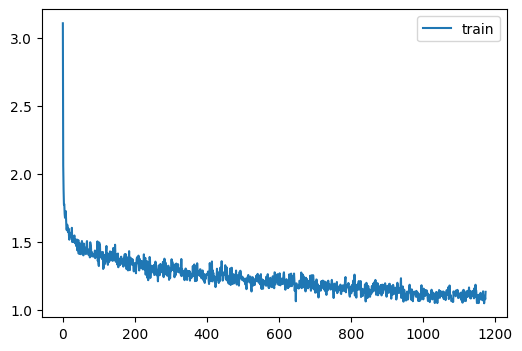

Fit 5 in: 137.89s, setup: 0.00s, 25.68 ± 3.74s per epoch, 0.04 ± 0.00s per batch


In [ ]:
rng.previous()
learn = run(
    get_model9(nn.SiLU, norm=nn.BatchNorm2d), leaky=0.0003, 
    base_lr=2e-2, epochs=5, 
    cbs=[], 
    train_cb=MixUp4CB(0.5, use_prev=True, eta=0.1, per_batch=False, loss_func=dmce, label_smoothing=0.1))

### Tests 20ep

Batch size 256
tensor([ 0.18487954, -2.29387426,  0.05842689])
tensor([4, 3, 8, 2, 9, 8, 2, 4, 6, 7, 5, 5, 6, 3, 7, 7, 9, 2, 1, 0, 8, 4, 1, 4, 8, 1, 5, 4, 8, 4, 2, 2, 5, 6, 3, 7, 3, 5, 8, 6, 6, 6, 8, 7,
        6, 6, 4, 5, 3, 0, 5, 8, 7, 1, 0, 3, 1, 5, 7, 0, 4, 0, 7, 5, 4, 6, 5, 8, 1, 5, 0, 0, 3, 4, 5, 4, 5, 0, 0, 4, 5, 4, 7, 5, 6, 5, 4, 6,
        3, 0, 2, 3, 0, 1, 7, 6, 4, 3, 1, 1, 7, 2, 1, 0, 1, 7, 9, 6, 9, 8, 4, 9, 2, 9, 1, 6, 8, 4, 4, 9, 5, 9, 8, 9, 0, 4, 1, 2, 3, 7, 7, 8,
        7, 0, 2, 4, 6, 2, 5, 2, 5, 5, 5, 1, 0, 4, 6, 6, 2, 2, 2, 0, 2, 8, 3, 3, 3, 9, 9, 0, 5, 5, 9, 8, 1, 5, 4, 7, 9, 2, 0, 3, 3, 4, 0, 1,
        0, 1, 1, 1, 0, 5, 5, 1, 0, 2, 1, 5, 9, 3, 1, 5, 8, 6, 0, 6, 2, 2, 5, 5, 9, 8, 4, 7, 6, 4, 7, 5, 0, 7, 3, 0, 2, 0, 2, 1, 7, 6, 8, 5,
        4, 8, 3, 8, 6, 6, 0, 9, 4, 9, 3, 0, 1, 9, 0, 9, 5, 2, 2, 6, 2, 6, 6, 9, 0, 2, 4, 7, 2, 5, 3, 6, 4, 0, 9, 1])
Using seed 1


accuracy,loss,epoch,train
0.737,1.595,0,train
0.881,0.479,0,eval
0.829,1.308,1,train
0.858,0.508,1,eval
0.841,1.253,2,train
0.897,0.423,2,eval
0.851,1.217,3,train
0.800,0.609,3,eval
0.861,1.189,4,train
0.900,0.392,4,eval


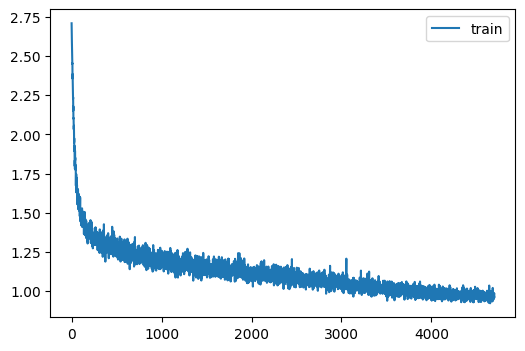

Fit 20 in: 561.66s, setup: 0.00s, 26.15 ± 0.19s per epoch, 0.05 ± 0.00s per batch
Using seed 1
Using seed 1
TTA: 0.952


In [ ]:
rng.previous()
tfms = nn.Sequential(transforms.RandomHorizontalFlip(0.65))
augcb = BatchTransformCB(partial(tfm_batch, tfm_x=tfms), on_val=False)

learn = run(timm.create_model('resnet18d', in_chans=1, num_classes=10, act_layer=nn.SiLU, pretrained=False), m=1, epochs=20,
            leaky=0.0003, cbs=[upscale_cb(4, 'bilinear'), augcb], 
            train_cb=MixUp4CB(0.4, use_prev=True, eta=0.1, per_batch=False, loss_func=dmce, label_smoothing=0.1), tta=True)

Batch size 256
tensor([-0.32495922,  0.12167471,  2.01532531])
tensor([9, 6, 9, 9, 3, 4, 7, 4, 9, 8, 4, 1, 8, 7, 6, 0, 8, 7, 1, 6, 0, 7, 7, 6, 6, 3, 1, 7, 0, 7, 9, 7, 4, 6, 7, 4, 3, 8, 2, 5, 5, 8, 2, 2,
        3, 5, 0, 1, 8, 1, 7, 0, 6, 6, 1, 7, 8, 6, 7, 3, 9, 7, 9, 7, 9, 7, 7, 5, 8, 6, 6, 2, 6, 4, 8, 6, 3, 4, 7, 9, 3, 4, 9, 5, 6, 6, 5, 7,
        6, 7, 2, 0, 5, 5, 5, 0, 4, 1, 9, 1, 0, 3, 2, 7, 6, 6, 1, 7, 9, 7, 1, 9, 1, 3, 6, 5, 3, 0, 0, 0, 1, 8, 1, 9, 3, 8, 0, 4, 7, 2, 9, 1,
        2, 4, 5, 0, 0, 0, 2, 5, 4, 2, 9, 9, 2, 8, 6, 0, 7, 4, 4, 2, 0, 7, 6, 0, 6, 3, 4, 1, 3, 9, 8, 5, 6, 2, 6, 2, 7, 9, 3, 4, 4, 2, 5, 6,
        7, 5, 4, 9, 2, 5, 7, 5, 2, 9, 2, 7, 0, 5, 4, 2, 4, 3, 5, 0, 5, 9, 1, 3, 6, 4, 0, 9, 9, 1, 7, 1, 1, 1, 0, 8, 5, 1, 1, 5, 3, 0, 2, 3,
        4, 1, 8, 6, 1, 3, 5, 6, 5, 6, 0, 0, 5, 5, 4, 0, 7, 7, 4, 8, 0, 1, 6, 9, 9, 1, 2, 5, 2, 3, 0, 5, 1, 5, 8, 5])
Using seed 1


accuracy,loss,epoch,train
0.783,1.472,0,train
0.859,0.548,0,eval
0.819,1.324,1,train
0.887,0.433,1,eval
0.827,1.272,2,train
0.899,0.390,2,eval
0.836,1.240,3,train
0.907,0.373,3,eval
0.840,1.215,4,train
0.906,0.369,4,eval


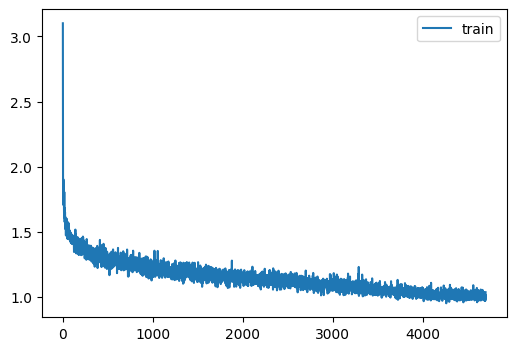

Fit 20 in: 513.54s, setup: 0.00s, 23.76 ± 0.05s per epoch, 0.04 ± 0.00s per batch
Using seed 1
Using seed 1
TTA: 0.9492


In [ ]:
rng.previous()
tfms = nn.Sequential(transforms.RandomHorizontalFlip(0.65))
augcb = BatchTransformCB(partial(tfm_batch, tfm_x=tfms), on_val=False)

learn = run(
    get_model9(nn.SiLU, norm=nn.BatchNorm2d), leaky=0.0003, 
    base_lr=2e-2, epochs=20, 
    cbs=[augcb], 
    train_cb=MixUp4CB(0.5, use_prev=True, eta=0.1, per_batch=False, loss_func=dmce, label_smoothing=0.1), tta=True)

Batch size 256
tensor([-0.32495922,  0.12167471,  2.01532531])
tensor([9, 6, 9, 9, 3, 4, 7, 4, 9, 8, 4, 1, 8, 7, 6, 0, 8, 7, 1, 6, 0, 7, 7, 6, 6, 3, 1, 7, 0, 7, 9, 7, 4, 6, 7, 4, 3, 8, 2, 5, 5, 8, 2, 2,
        3, 5, 0, 1, 8, 1, 7, 0, 6, 6, 1, 7, 8, 6, 7, 3, 9, 7, 9, 7, 9, 7, 7, 5, 8, 6, 6, 2, 6, 4, 8, 6, 3, 4, 7, 9, 3, 4, 9, 5, 6, 6, 5, 7,
        6, 7, 2, 0, 5, 5, 5, 0, 4, 1, 9, 1, 0, 3, 2, 7, 6, 6, 1, 7, 9, 7, 1, 9, 1, 3, 6, 5, 3, 0, 0, 0, 1, 8, 1, 9, 3, 8, 0, 4, 7, 2, 9, 1,
        2, 4, 5, 0, 0, 0, 2, 5, 4, 2, 9, 9, 2, 8, 6, 0, 7, 4, 4, 2, 0, 7, 6, 0, 6, 3, 4, 1, 3, 9, 8, 5, 6, 2, 6, 2, 7, 9, 3, 4, 4, 2, 5, 6,
        7, 5, 4, 9, 2, 5, 7, 5, 2, 9, 2, 7, 0, 5, 4, 2, 4, 3, 5, 0, 5, 9, 1, 3, 6, 4, 0, 9, 9, 1, 7, 1, 1, 1, 0, 8, 5, 1, 1, 5, 3, 0, 2, 3,
        4, 1, 8, 6, 1, 3, 5, 6, 5, 6, 0, 0, 5, 5, 4, 0, 7, 7, 4, 8, 0, 1, 6, 9, 9, 1, 2, 5, 2, 3, 0, 5, 1, 5, 8, 5])
Using seed 1


accuracy,loss,epoch,train
0.796,1.429,0,train
0.890,0.473,0,eval
0.825,1.297,1,train
0.891,0.441,1,eval
0.834,1.250,2,train
0.907,0.360,2,eval
0.840,1.221,3,train
0.914,0.354,3,eval
0.851,1.194,4,train
0.889,0.417,4,eval


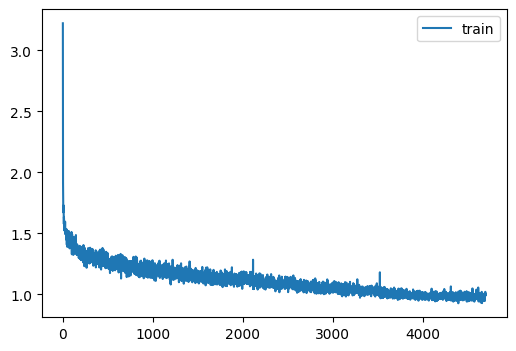

Fit 20 in: 513.54s, setup: 0.00s, 23.77 ± 0.06s per epoch, 0.04 ± 0.00s per batch
Using seed 1
Using seed 1
TTA: 0.918


In [ ]:
rng.previous()
learn = run(
    get_model9(nn.SiLU, norm=nn.BatchNorm2d), leaky=0.0003, 
    base_lr=2e-2, epochs=20, 
    cbs=[], 
    train_cb=MixUp4CB(0.5, use_prev=True, eta=0.1, per_batch=False, loss_func=dmce, label_smoothing=0.1), tta=True)

Batch size 256
tensor([ 0.18487954, -2.29387426,  0.05842689])
tensor([4, 3, 8, 2, 9, 8, 2, 4, 6, 7, 5, 5, 6, 3, 7, 7, 9, 2, 1, 0, 8, 4, 1, 4, 8, 1, 5, 4, 8, 4, 2, 2, 5, 6, 3, 7, 3, 5, 8, 6, 6, 6, 8, 7,
        6, 6, 4, 5, 3, 0, 5, 8, 7, 1, 0, 3, 1, 5, 7, 0, 4, 0, 7, 5, 4, 6, 5, 8, 1, 5, 0, 0, 3, 4, 5, 4, 5, 0, 0, 4, 5, 4, 7, 5, 6, 5, 4, 6,
        3, 0, 2, 3, 0, 1, 7, 6, 4, 3, 1, 1, 7, 2, 1, 0, 1, 7, 9, 6, 9, 8, 4, 9, 2, 9, 1, 6, 8, 4, 4, 9, 5, 9, 8, 9, 0, 4, 1, 2, 3, 7, 7, 8,
        7, 0, 2, 4, 6, 2, 5, 2, 5, 5, 5, 1, 0, 4, 6, 6, 2, 2, 2, 0, 2, 8, 3, 3, 3, 9, 9, 0, 5, 5, 9, 8, 1, 5, 4, 7, 9, 2, 0, 3, 3, 4, 0, 1,
        0, 1, 1, 1, 0, 5, 5, 1, 0, 2, 1, 5, 9, 3, 1, 5, 8, 6, 0, 6, 2, 2, 5, 5, 9, 8, 4, 7, 6, 4, 7, 5, 0, 7, 3, 0, 2, 0, 2, 1, 7, 6, 8, 5,
        4, 8, 3, 8, 6, 6, 0, 9, 4, 9, 3, 0, 1, 9, 0, 9, 5, 2, 2, 6, 2, 6, 6, 9, 0, 2, 4, 7, 2, 5, 3, 6, 4, 0, 9, 1])
Using seed 1


accuracy,loss,epoch,train
0.733,1.879,0,train
0.874,0.543,0,eval
0.821,1.537,1,train
0.850,0.514,1,eval
0.833,1.466,2,train
0.900,0.411,2,eval
0.847,1.419,3,train
0.895,0.464,3,eval
0.854,1.386,4,train
0.899,0.427,4,eval


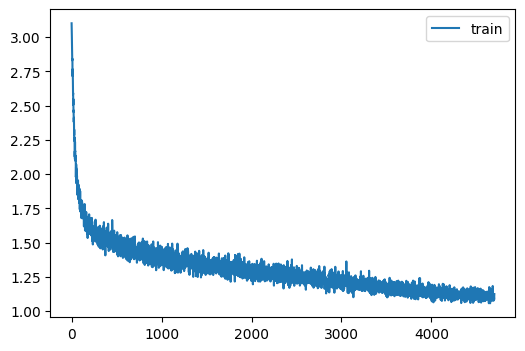

Fit 20 in: 560.52s, setup: 0.00s, 26.12 ± 0.10s per epoch, 0.05 ± 0.00s per batch
Using seed 1
Using seed 1
TTA: 0.9501


In [ ]:
rng.previous()
tfms = nn.Sequential(transforms.RandomHorizontalFlip(0.65))
augcb = BatchTransformCB(partial(tfm_batch, tfm_x=tfms), on_val=False)

learn = run(timm.create_model('resnet18d', in_chans=1, num_classes=10, act_layer=nn.SiLU, pretrained=False), m=1, epochs=20,
            leaky=0.0003, cbs=[upscale_cb(4, 'bilinear'), augcb], 
            train_cb=MixUp4CB(0.4, use_prev=True, eta=0.2, per_batch=False, loss_func=dmce, label_smoothing=0.1), tta=True)

In [ ]:
## 50ep

Batch size 256
tensor([ 0.18487954, -2.29387426,  0.05842689])
tensor([4, 3, 8, 2, 9, 8, 2, 4, 6, 7, 5, 5, 6, 3, 7, 7, 9, 2, 1, 0, 8, 4, 1, 4, 8, 1, 5, 4, 8, 4, 2, 2, 5, 6, 3, 7, 3, 5, 8, 6, 6, 6, 8, 7,
        6, 6, 4, 5, 3, 0, 5, 8, 7, 1, 0, 3, 1, 5, 7, 0, 4, 0, 7, 5, 4, 6, 5, 8, 1, 5, 0, 0, 3, 4, 5, 4, 5, 0, 0, 4, 5, 4, 7, 5, 6, 5, 4, 6,
        3, 0, 2, 3, 0, 1, 7, 6, 4, 3, 1, 1, 7, 2, 1, 0, 1, 7, 9, 6, 9, 8, 4, 9, 2, 9, 1, 6, 8, 4, 4, 9, 5, 9, 8, 9, 0, 4, 1, 2, 3, 7, 7, 8,
        7, 0, 2, 4, 6, 2, 5, 2, 5, 5, 5, 1, 0, 4, 6, 6, 2, 2, 2, 0, 2, 8, 3, 3, 3, 9, 9, 0, 5, 5, 9, 8, 1, 5, 4, 7, 9, 2, 0, 3, 3, 4, 0, 1,
        0, 1, 1, 1, 0, 5, 5, 1, 0, 2, 1, 5, 9, 3, 1, 5, 8, 6, 0, 6, 2, 2, 5, 5, 9, 8, 4, 7, 6, 4, 7, 5, 0, 7, 3, 0, 2, 0, 2, 1, 7, 6, 8, 5,
        4, 8, 3, 8, 6, 6, 0, 9, 4, 9, 3, 0, 1, 9, 0, 9, 5, 2, 2, 6, 2, 6, 6, 9, 0, 2, 4, 7, 2, 5, 3, 6, 4, 0, 9, 1])
Using seed 1


accuracy,loss,epoch,train
0.734,1.880,0,train
0.854,0.521,0,eval
0.827,1.522,1,train
0.796,0.669,1,eval
0.834,1.465,2,train
0.858,0.562,2,eval
0.844,1.426,3,train
0.905,0.419,3,eval
0.852,1.396,4,train
0.899,0.424,4,eval


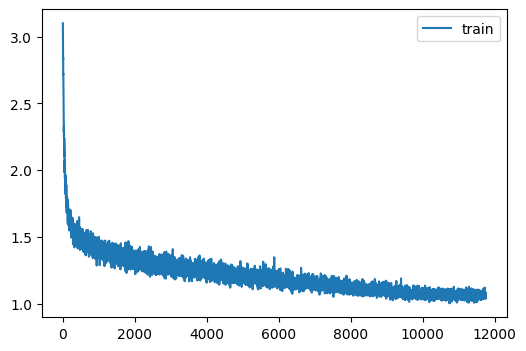

Fit 50 in: 1404.41s, setup: 0.00s, 26.17 ± 0.08s per epoch, 0.05 ± 0.00s per batch
Using seed 1
Using seed 1
TTA: 0.9524


In [ ]:
rng.previous()
tfms = nn.Sequential(transforms.RandomHorizontalFlip(0.65))
augcb = BatchTransformCB(partial(tfm_batch, tfm_x=tfms), on_val=False)

learn = run(timm.create_model('resnet18d', in_chans=1, num_classes=10, act_layer=nn.SiLU, pretrained=False), m=1, epochs=50,
            leaky=0.0003, cbs=[upscale_cb(4, 'bilinear'), augcb], 
            train_cb=MixUp4CB(0.4, use_prev=True, eta=0.2, per_batch=False, loss_func=dmce, label_smoothing=0.1), tta=True)

Batch size 256
tensor([ 0.18487954, -2.29387426,  0.05842689])
tensor([4, 3, 8, 2, 9, 8, 2, 4, 6, 7, 5, 5, 6, 3, 7, 7, 9, 2, 1, 0, 8, 4, 1, 4, 8, 1, 5, 4, 8, 4, 2, 2, 5, 6, 3, 7, 3, 5, 8, 6, 6, 6, 8, 7,
        6, 6, 4, 5, 3, 0, 5, 8, 7, 1, 0, 3, 1, 5, 7, 0, 4, 0, 7, 5, 4, 6, 5, 8, 1, 5, 0, 0, 3, 4, 5, 4, 5, 0, 0, 4, 5, 4, 7, 5, 6, 5, 4, 6,
        3, 0, 2, 3, 0, 1, 7, 6, 4, 3, 1, 1, 7, 2, 1, 0, 1, 7, 9, 6, 9, 8, 4, 9, 2, 9, 1, 6, 8, 4, 4, 9, 5, 9, 8, 9, 0, 4, 1, 2, 3, 7, 7, 8,
        7, 0, 2, 4, 6, 2, 5, 2, 5, 5, 5, 1, 0, 4, 6, 6, 2, 2, 2, 0, 2, 8, 3, 3, 3, 9, 9, 0, 5, 5, 9, 8, 1, 5, 4, 7, 9, 2, 0, 3, 3, 4, 0, 1,
        0, 1, 1, 1, 0, 5, 5, 1, 0, 2, 1, 5, 9, 3, 1, 5, 8, 6, 0, 6, 2, 2, 5, 5, 9, 8, 4, 7, 6, 4, 7, 5, 0, 7, 3, 0, 2, 0, 2, 1, 7, 6, 8, 5,
        4, 8, 3, 8, 6, 6, 0, 9, 4, 9, 3, 0, 1, 9, 0, 9, 5, 2, 2, 6, 2, 6, 6, 9, 0, 2, 4, 7, 2, 5, 3, 6, 4, 0, 9, 1])
Using seed 1


accuracy,loss,epoch,train
0.738,1.594,0,train
0.874,0.486,0,eval
0.834,1.293,1,train
0.858,0.550,1,eval
0.841,1.249,2,train
0.901,0.489,2,eval
0.851,1.218,3,train
0.914,0.358,3,eval
0.859,1.197,4,train
0.904,0.383,4,eval


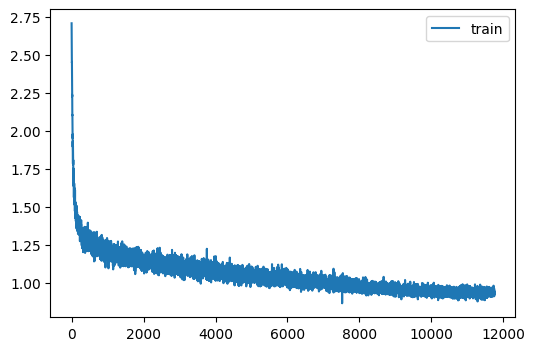

Fit 50 in: 1405.88s, setup: 0.00s, 26.18 ± 0.08s per epoch, 0.05 ± 0.00s per batch
Using seed 1
Using seed 1
TTA: 0.9519


In [ ]:
rng.previous()
tfms = nn.Sequential(transforms.RandomHorizontalFlip(0.65))
augcb = BatchTransformCB(partial(tfm_batch, tfm_x=tfms), on_val=False)

learn = run(timm.create_model('resnet18d', in_chans=1, num_classes=10, act_layer=nn.SiLU, pretrained=False), m=1, epochs=50,
            leaky=0.0003, cbs=[upscale_cb(4, 'bilinear'), augcb], 
            train_cb=MixUp4CB(0.4, use_prev=True, eta=0.1, per_batch=False, loss_func=dmce, label_smoothing=0.1), tta=True)

In [ ]:
clean_tb()
clean_ipython_hist()
clean_mem()